# LMTM

이정재  
2024-01-31

## \## Sentimental Analysis

-   **many to one**
    -   영화 리뷰 텍스트(many)를 입력으로 받아 긍정 또는 부정(one)을
        출력하는 구조
    -   **Embedding**: 영화 리뷰(text)를 벡터로 변환하는 연산
    -   **LSTM**: 시계열 데이터를 처리하기 위한 구조
    -   **Linear**: 결과 출력

## `Step 1` : Load libraries & Datsets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [2]:
data = pd.read_csv('exercise4.csv')
data.head()

In [3]:
data['processed'][0]

In [4]:
data['processed'] = data['processed'].str.lower().replace(r"[^a-zA-Z ]", "", regex=True)

In [5]:
data['processed'][0]

### - 사전생성

-   리뷰 문장에 들어있는 단어들을 추출하고, 각각의 단어에 숫자를
    부여하는 작업
-   \[‘one’, ‘reviewer’, ‘mentioned’, ‘watching’, ‘oz’, ‘episode’,
    ‘hooked’\]

In [7]:
# 문장에 포함된 단어 토큰화
reviews = data['processed'].values
words = ' '.join(reviews).split()
words[:10]

In [63]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}
#word2int

In [26]:
word2int['<PAD>']

### - 리뷰 인코딩

-   리뷰에 포함된 단어를 숫자형태로 변환하는 작업
-   {‘i’: 1, ‘movie’: 2, ‘film’: 3, ‘the’: 4, ‘one’: 5, ‘like’: 6, ‘it’:
    7, ‘time’: 8, ‘this’: 9, ‘good’: 10, ‘character’: 11,…}

In [9]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 24930.36it/s]

In [10]:
reviews_enc[0][1:10]

In [11]:
data['processed'][0]

In [12]:
word2int['one'], word2int['reviewer'], word2int['mentioned']

In [13]:
data['encoded'] = reviews_enc
data['encoded']

### - 길이 맞춰주기(padding or trim)

-   신경망의 입력으로 사용하기 위해 일정 길이만큼 맞춰주는 작업
-   길이가 긴 문장은 잘라주고(trim), 길이가 짧은 문장은
    채워주는(padding) 작업

In [49]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

In [64]:
np.full((5,3),2)

In [50]:
word2int['<PAD>']

In [51]:
labels = data['label'].to_numpy()
labels

### - 데이터 분할

In [52]:
# train test split
train_size = .8
split_id = int(len(features) * train_size)
train_x, test_x, train_y, test_y = features[:split_id], features[split_id:], labels[:split_id], labels[split_id:]

split_id = int(len(train_x) * train_size)
train_x, valid_x, train_y, valid_y = train_x[:split_id], train_x[split_id:], train_y[:split_id], train_y[split_id:]

print('Train X shape: {}, Valid X shape: {}, Test X shape: {}'.format(train_x.shape, valid_x.shape, test_x.shape))
print('Train y shape: {}, Valid y shape: {}, Test y shape: {}'.format(train_y.shape, valid_y.shape, test_y.shape))

Train X shape: (32000, 256), Valid X shape: (8000, 256), Test X shape: (10000, 256)
Train y shape: (32000,), Valid y shape: (8000,), Test y shape: (10000,)

## `Step 2` : Create DataLoader

In [53]:
# set hyperparameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

lr = 0.001
batch_size = 128
vocab_size = len(word2int)
embedding_size = 256
dropout = 0.25

epochs = 8
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}

es_limit = 5

cuda

In [54]:
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

## `Step 3` : Set Network Structure

In [55]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size=400):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 512, 2, dropout=0.25, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ = self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)

        return o

## `Step 4` : Create Model instance

In [56]:
model = LSTMClassifier(vocab_size, embedding_size).to(device)
print(model)

LSTMClassifier(
  (embedding): Embedding(96140, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## `Step 5` : Model compile

In [57]:
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)

## `Step 6` : Set train loop

In [58]:
def train(model, trainloader):
    model.train()

    train_loss = 0
    train_acc = 0

    for id, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.squeeze(), y.float())
        loss.backward()
        optim.step()

        train_loss += loss.item()
        y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
        equals = y_pred == y
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    return train_loss, train_acc

## `Step 7` : Set test loop

In [59]:
def validation(model, valloader):
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (X,y) in enumerate(valloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y.float())

            val_loss += loss.item()

            y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
            equals = y_pred == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    return val_loss, val_acc

    
    

## `Step 8` : Run Model

In [60]:
# train loop
epochloop = tqdm(range(epochs), desc='Training')

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    train_loss, train_acc = train(model, trainloader)
    val_loss, val_acc = validation(model, valloader)
    epochloop.write(f'Epoch[{e+1}/{epochs}] Train Loss: {train_loss / len(trainloader):.3f}, Train Acc: {train_acc / len(trainloader):.3f}, Val Loss: {val_loss / len(valloader):.3f}, Val Acc: {val_acc / len(valloader):.3f}')

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min=val_loss / len(valloader)
        es_trigger = 0

    else:
        es_trigger += 1

    # early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history['epochs'] = e+1
        break

Training:   0%|                                                                                   | 0/8 [00:12<?, ?it/s]Training:  25%|██████████████████▊                                                        | 2/8 [00:23<01:10, 11.75s/it]Training:  25%|██████████████████▊                                                        | 2/8 [00:32<01:10, 11.75s/it]Training:  38%|████████████████████████████▏                                              | 3/8 [00:42<00:53, 10.67s/it]Training:  50%|█████████████████████████████████████▌                                     | 4/8 [00:51<00:40, 10.24s/it]Training:  62%|██████████████████████████████████████████████▉                            | 5/8 [01:01<00:29,  9.82s/it]Training:  88%|█████████████████████████████████████████████████████████████████▋         | 7/8 [01:11<00:09,  9.95s/it]Training: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [01:21<00:00, 10.20s/it]

Epoch[1/8] Train Loss: 0.694, Train Acc: 0.506, Val Loss: 0.692, Val Acc: 0.496
Epoch[2/8] Train Loss: 0.694, Train Acc: 0.506, Val Loss: 0.692, Val Acc: 0.514
Epoch[3/8] Train Loss: 0.669, Train Acc: 0.570, Val Loss: 0.650, Val Acc: 0.706
Epoch[4/8] Train Loss: 0.478, Train Acc: 0.800, Val Loss: 0.601, Val Acc: 0.772
Epoch[5/8] Train Loss: 0.448, Train Acc: 0.811, Val Loss: 0.405, Val Acc: 0.818
Epoch[6/8] Train Loss: 0.314, Train Acc: 0.879, Val Loss: 0.357, Val Acc: 0.847
Epoch[7/8] Train Loss: 0.237, Train Acc: 0.914, Val Loss: 0.384, Val Acc: 0.842
Epoch[8/8] Train Loss: 0.203, Train Acc: 0.932, Val Loss: 0.426, Val Acc: 0.856

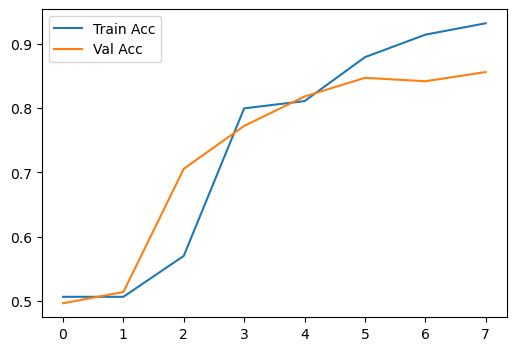

In [61]:
# plot loss
plt.figure(figsize=(6,4))
plt.plot(range(history['epochs']), history['train_acc'][:history['epochs']], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'][:history['epochs']], label='Val Acc')
plt.legend()
plt.show()

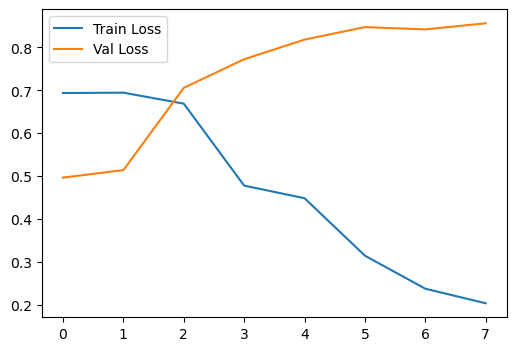

In [62]:
# plot loss
plt.figure(figsize=(6,4))
plt.plot(range(history['epochs']), history['train_loss'][:history['epochs']], label='Train Loss')
plt.plot(range(history['epochs']), history['val_acc'][:history['epochs']], label='Val Loss')
plt.legend()
plt.show()